# **Installation**

In [28]:
!wget https://awards.opdc.go.th/awards_opdc/assets/fonts/THSarabunNew/THSarabunNew.ttf
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
!apt install fonts-thai-tlwg
!pip install --upgrade pythainlp
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip

--2021-06-18 16:48:46--  https://awards.opdc.go.th/awards_opdc/assets/fonts/THSarabunNew/THSarabunNew.ttf
Resolving awards.opdc.go.th (awards.opdc.go.th)... 164.115.76.22
Connecting to awards.opdc.go.th (awards.opdc.go.th)|164.115.76.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18054 (18K) [text/html]
Saving to: ‘THSarabunNew.ttf.3’

THSarabunNew.ttf.3  100%[===================>]  17.63K  --.-KB/s    in 0s      

2021-06-18 16:48:50 (266 MB/s) - ‘THSarabunNew.ttf.3’ saved [18054/18054]

replace THSarabunChula-Regular.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-thai-tlwg is already the newest version (1:0.6.4-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Requirement already up-to-date: pythainlp in /usr/local/lib/python3.7/dist-packages (2.3.1)
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Created wheel for

# **Import Libraries**

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams
from datetime import date
import seaborn as sns

import pythainlp 
from pythainlp.corpus.common import *
from pythainlp.util import normalize
from pythainlp import Tokenizer

# Set font
font_list = fm.createFontList(['THSarabunChula-Regular.ttf'])
print(font_list)
fm.fontManager.ttflist.extend(font_list)
# fm.fontManager.addfont(font_list)
plt.rcParams['font.family'] = 'TH Sarabun Chula'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
csfont = {'fontname':'TH Sarabun Chula'}

[<Font 'TH Sarabun Chula' (THSarabunChula-Regular.ttf) normal normal regular normal>]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


# **Import Data**

In [30]:
# get a dataframe from xlsx object
# *change github url into raw github url for valid data retrieving
url = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/fd14ca3a3a06f63bd23bd24e0cbae9330e8de2eb/HOMEWORK%2001/Customer%20Behaviors%20(Responses).xlsx'
xls = pd.ExcelFile(url)
df = pd.read_excel(xls, 'Form Responses 1')
df.head(5)

,Timestamp,คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารญี่ปุ่น],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารจึน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารไทย],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารอีสาน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารสุขภาพ],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [บุฟเฟต์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ชาบูชาบู],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ปิ้งย่าง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [เหล้าเบียร์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [เสื้อผ้าแฟชั่น],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [แต่งหน้า],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [skincare บำรุงผิว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การออกกำลังกาย],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การเล่นเกมส์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การท่องเที่ยว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การอ่านหนังสือ],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การอ่านบทความ Online],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การเรียน e-learning],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Series],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดูหนัง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Youtube],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Netflix],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content ด้านบันเทิง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่่ยวกับเกมส์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการ review ร้านอาหาร],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการท่องเที่ยว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการแต่งบ้าน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการโทรทัศน์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับละคร],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการเมือง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารญี่ปุ่น],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารจึน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารไทย],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารอีสาน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารสุขภาพ],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [บุฟเฟต์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ชาบูชาบู],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ปิ้งย่าง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [เหล้าเบียร์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [เสื้อผ้าแฟชั่น],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [แต่งหน้า],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [skincare บำรุงผิว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การออกกำลังกาย],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การเล่นเกมส์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การท่องเที่ยว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การอ่านหนังสือ],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การอ่านบทความ Online],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การเรียน e-learning],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Series],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดูหนัง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Youtube],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Netflix],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content ด้านบันเทิง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่่ยวกับเกมส์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการ review ร้านอาหาร],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการท่องเที่ยว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการแต่งบ้าน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการโทรทัศน์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับละคร],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการเมือง],นอกเหนือจากรายการดังกล่าวแล้ว คุณมีความสนใจในเรื่องใดอีกบ้าง,คุณเกิดวันที่เท่าไหร่,เพศ
0,2021-01-09 10:07:27.365,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 คร

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 64 columns):
 #   Column                                                                             Non-Null Count  Dtype         
---  ------                                                                             --------------  -----         
 0   Timestamp                                                                          63 non-null     datetime64[ns]
 1   คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารญี่ปุ่น]                           63 non-null     object        
 2   คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารจึน]                               63 non-null     object        
 3   คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารไทย]                               63 non-null     object        
 4   คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารอีสาน]                             63 non-null     object        
 5   คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารสุขภาพ]    

# **Cleaning**

In [32]:
 # drop first column
df.drop(df.columns[0], axis=1, inplace=True)  

 # Edit header column
df.columns = df.columns.str.replace(r'(คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด)', 'Interest', regex=True).str.strip()
df.columns = df.columns.str.replace(r'(คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน)', 'Consume', regex=True).str.strip()
df.columns = df.columns.str.replace(r'(นอกเหนือจากรายการดังกล่าวแล้ว คุณมีความสนใจในเรื่องใดอีกบ้าง)', 'Remark', regex=True).str.strip()
df.columns = df.columns.str.replace(r'(คุณเกิดวันที่เท่าไหร่)', 'BirthDay', regex=True).str.strip()
df.columns = df.columns.str.replace(r'(เพศ)', 'Gender', regex=True).str.strip()
df['Gender'] = df['Gender'].str.replace('ชาย','M')
df['Gender'] = df['Gender'].str.replace('หญิง','F')


 # add new coloumn "Age" by calculate from birth date
age = []
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

for d in df['BirthDay']:
    if d.year > 2500:                # fix พศ -> คศ
       y = d.year - 543
       d = d.replace(year=y)      
    age.append(int(calculate_age(d)))
df['Age'] = age

# **View Distribution**

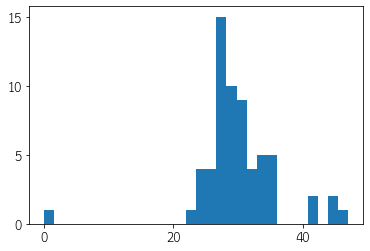

In [33]:
df['Age'].hist(grid=False, bins=30)

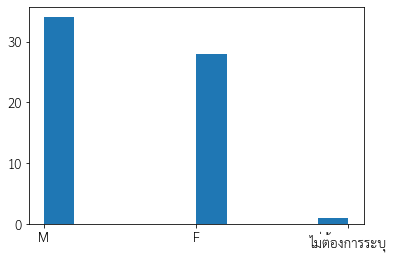

In [34]:
df['Gender'].hist(grid=False)
df = df.loc[df['Gender'] != 'ไม่ต้องการระบุ']   # just one record

# Frequency plot 

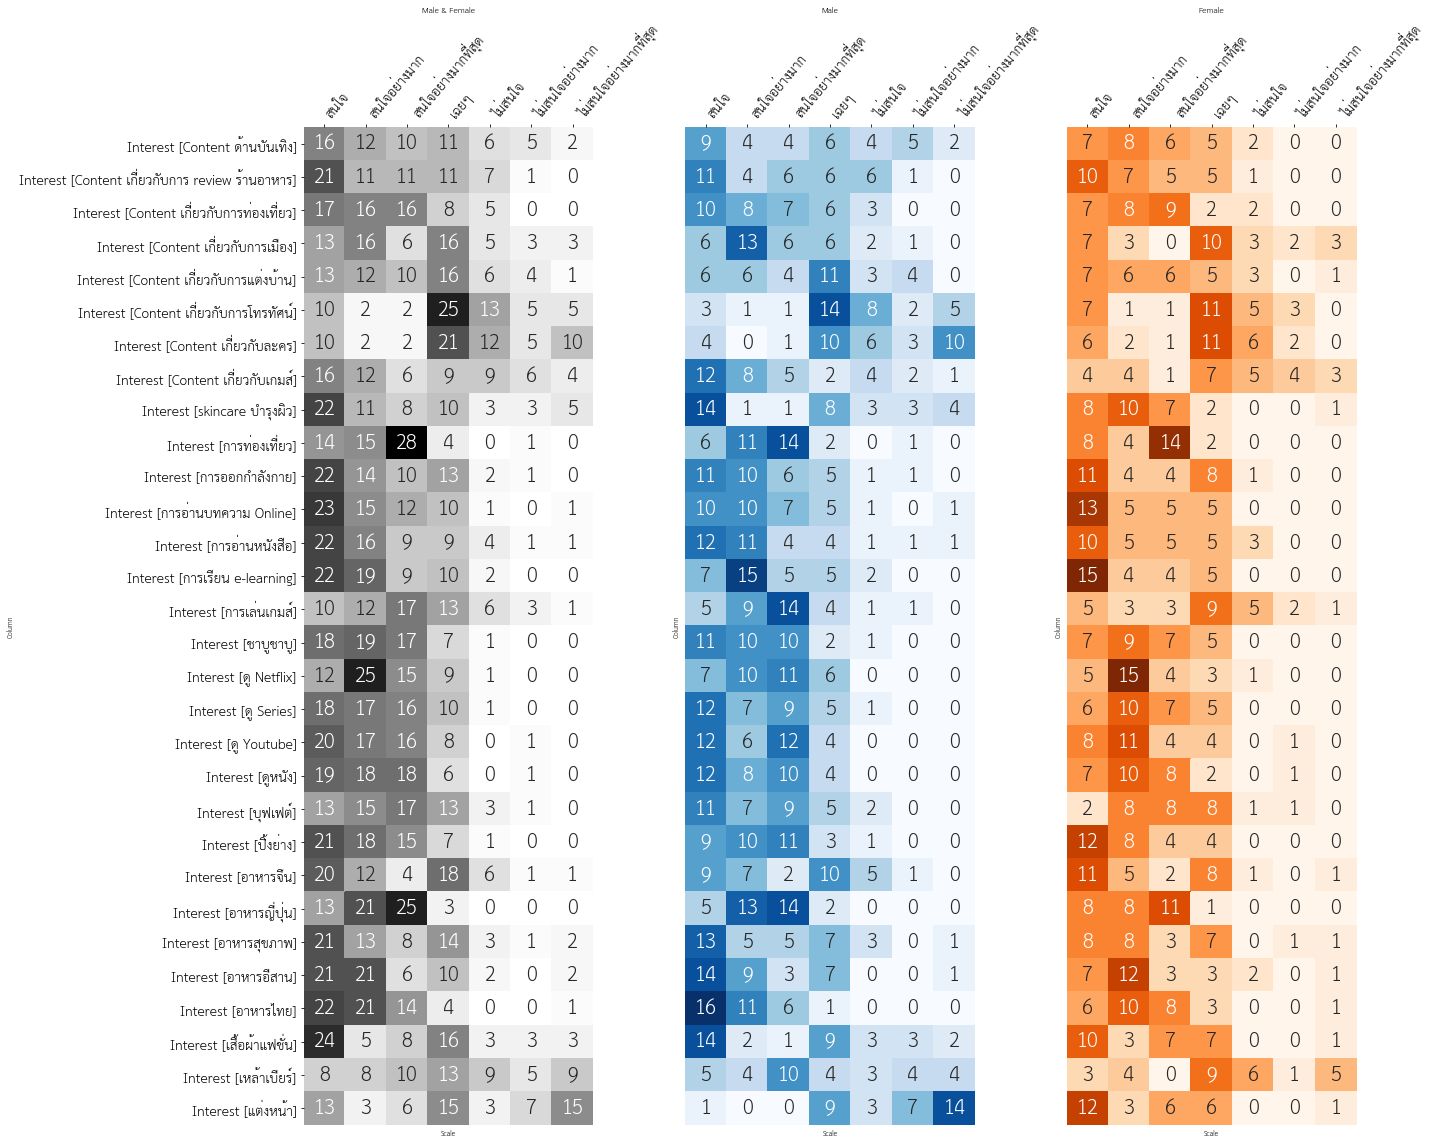

In [35]:
df_i_mf = df.iloc[:,:30].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_i_mf = df_i_mf.size().pivot('Column','Scale','size').fillna(0)
df_i_m = df[df['Gender']=='M'].iloc[:,:30].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_i_m = df_i_m.size().pivot('Column','Scale','size').fillna(0)
df_i_f = df[df['Gender']=='F'].iloc[:,:30].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_i_f = df_i_f.size().pivot('Column','Scale','size').fillna(0)

plt.subplots(1,3, figsize=(20,16), tight_layout=True)

#1
plt.subplot(1,3,1)
ax = sns.heatmap(df_i_mf, cmap='Greys', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Male & Female')

#2
plt.subplot(1,3,2)
ax = sns.heatmap(df_i_m, cmap='Blues', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Male')
ax.set_yticks([])

#3
plt.subplot(1,3,3)
ax = sns.heatmap(df_i_f, cmap='Oranges', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Female')
ax.set_yticks([])

plt.show()

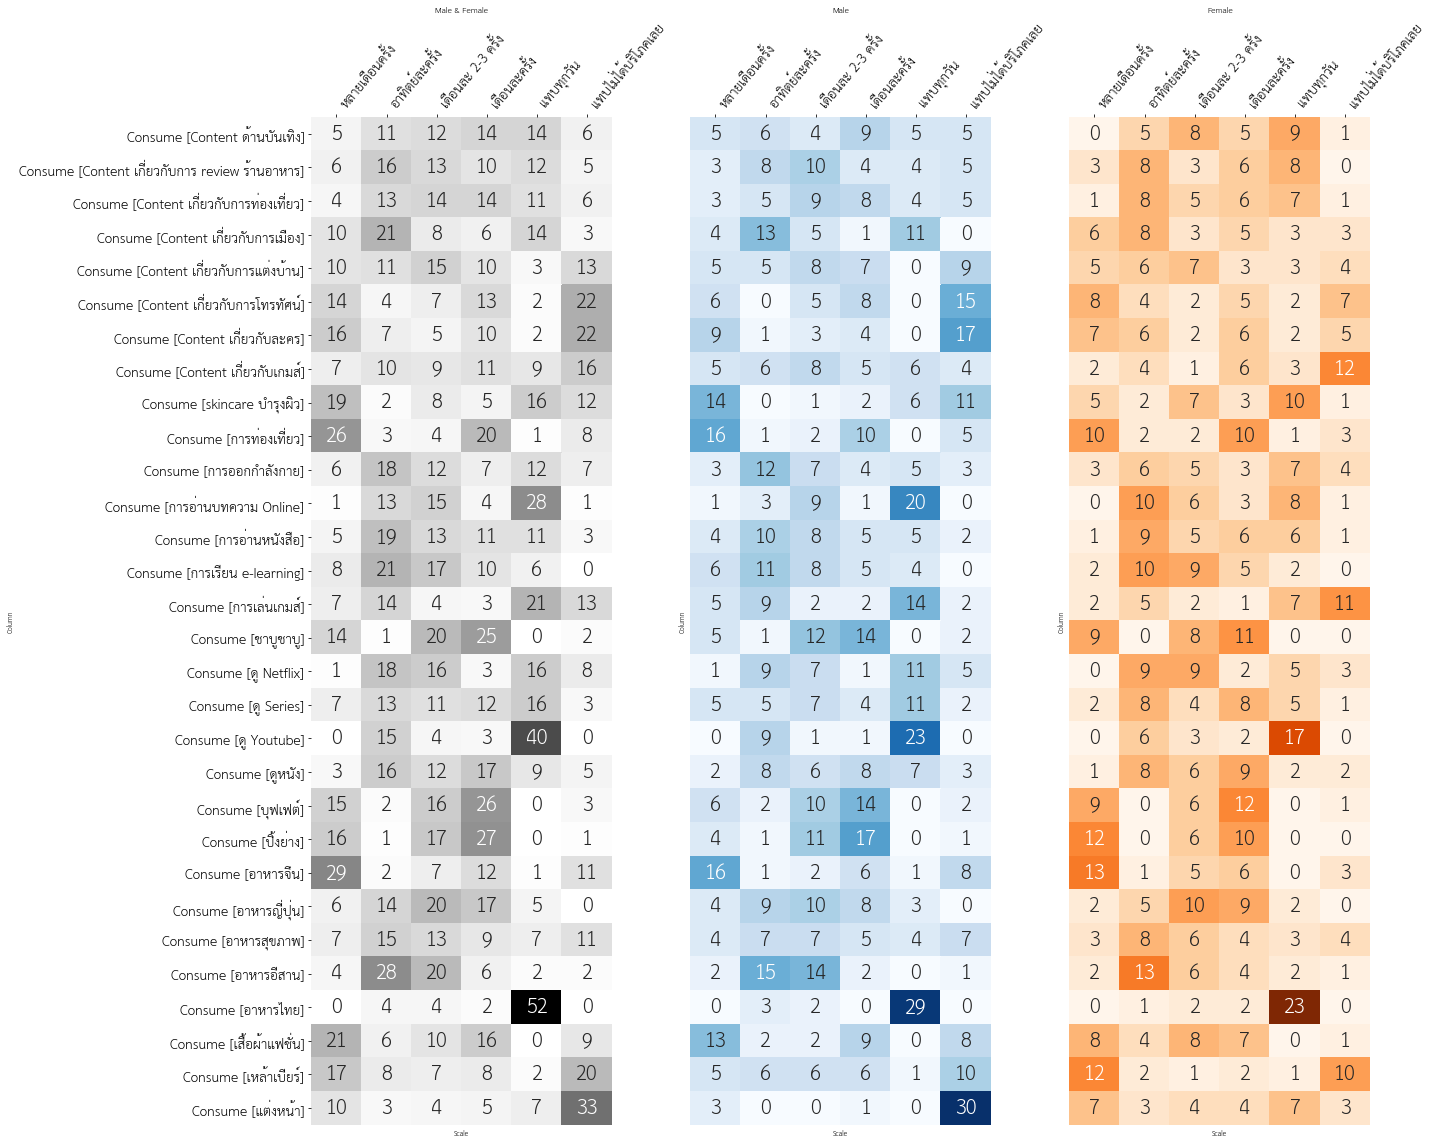

In [36]:
df_c_mf = df.iloc[:,30:60].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_c_mf = df_c_mf.size().pivot('Column','Scale','size').fillna(0)
df_c_m = df[df['Gender']=='M'].iloc[:,30:60].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_c_m = df_c_m.size().pivot('Column','Scale','size').fillna(0)
df_c_f = df[df['Gender']=='F'].iloc[:,30:60].melt(var_name='Column', value_name='Scale').groupby(['Scale','Column'], as_index=False)
df_c_f = df_c_f.size().pivot('Column','Scale','size').fillna(0)

plt.subplots(1,3, figsize=(20,16), tight_layout=True)

#1
plt.subplot(1,3,1)
ax = sns.heatmap(df_c_mf, cmap='Greys', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Male & Female')

#2
plt.subplot(1,3,2)
ax = sns.heatmap(df_c_m, cmap='Blues', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Male')
ax.set_yticks([])

#3
plt.subplot(1,3,3)
ax = sns.heatmap(df_c_f, cmap='Oranges', annot=True, vmin=0, cbar=False, annot_kws={"size": 30 })
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='left')
ax.xaxis.set_ticks_position('top')
ax.set_title('Female')
ax.set_yticks([])

plt.show()

## Correlation

In [37]:
# mapping categorical data with scale
int_scale = {'ไม่สนใจอย่างมากที่สุด': 1, 'ไม่สนใจอย่างมาก': 2, 'ไม่สนใจ': 3, 'เฉยๆ': 4, 'สนใจ': 5, 'สนใจอย่างมาก': 6, 'สนใจอย่างมากที่สุด': 7}
con_scale = {'แทบไม่ได้บริโภคเลย': 1, 'หลายเดือนครั้ง': 2, 'เดือนละครั้ง': 3, 'เดือนละ 2-3 ครั้ง': 4, 'อาทิตย์ละครั้ง': 5, 'แทบทุกวัน': 6}
df_cop = df.copy()
for col in df_cop.columns[:30]:
    df_cop[col] = df_cop[col].map(int_scale)
for col in df_cop.columns[30:60]:
    df_cop[col] = df_cop[col].map(con_scale)
df_tmp = df_cop[list(df.columns[:60])]

In [38]:
df_tmp.head()

,Interest [อาหารญี่ปุ่น],Interest [อาหารจึน],Interest [อาหารไทย],Interest [อาหารอีสาน],Interest [อาหารสุขภาพ],Interest [บุฟเฟต์],Interest [ชาบูชาบู],Interest [ปิ้งย่าง],Interest [เหล้าเบียร์],Interest [เสื้อผ้าแฟชั่น],Interest [แต่งหน้า],Interest [skincare บำรุงผิว],Interest [การออกกำลังกาย],Interest [การเล่นเกมส์],Interest [การท่องเที่ยว],Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],Interest [การเรียน e-learning],Interest [ดู Series],Interest [ดูหนัง],Interest [ดู Youtube],Interest [ดู Netflix],Interest [Content ด้านบันเทิง],Interest [Content เกี่่ยวกับเกมส์],Interest [Content เกี่ยวกับการ review ร้านอาหาร],Interest [Content เกี่ยวกับการท่องเที่ยว],Interest [Content เกี่ยวกับการแต่งบ้าน],Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],Interest [Content เกี่ยวกับการเมือง],Consume [อาหารญี่ปุ่น],Consume [อาหารจึน],Consume [อาหารไทย],Consume [อาหารอีสาน],Consume [อาหารสุขภาพ],Consume [บุฟเฟต์],Consume [ชาบูชาบู],Consume [ปิ้งย่าง],Consume [เหล้าเบียร์],Consume [เสื้อผ้าแฟชั่น],Consume [แต่งหน้า],Consume [skincare บำรุงผิว],Consume [การออกกำลังกาย],Consume [การเล่นเกมส์],Consume [การท่องเที่ยว],Consume [การอ่านหนังสือ],Consume [การอ่านบทความ Online],Consume [การเรียน e-learning],Consume [ดู Series],Consume [ดูหนัง],Consume [ดู Youtube],Consume [ดู Netflix],Consume [Content ด้านบันเทิง],Consume [Content เกี่่ยวกับเกมส์],Consume [Content เกี่ยวกับการ review ร้านอาหาร],Consume [Content เกี่ยวกับการท่องเที่ยว],Consume [Content เกี่ยวกับการแต่งบ้าน],Consume [Content เกี่ยวกับการโทรทัศน์],Consume [Content เกี่ยวกับละคร],Consume [Content เกี่ยวกับการเมือง]
0,5,5,7,6,5,5,5,5,7,4,3,5,6,6,4,5,5,7,6,6,5,7,5,6,6,4,4,4,4,7,4,2,6,5,6,4,4,3,5,2,2,6,6,5,4,4,4,4,4,5,5,5,2,3,4,4,4,4,4,6
1,6,4,7,6,5,6,7,6,3,4,4,4,6,6,7,7,7,7,4,7,7,6,4,4,6,7,7,4,3,5,5,2,6,5,5,4,4,4,1,3,1,3,6,6,3,6,6,5,2,5,6,4,3,4,6,6,5,2,2,5
2,7,4,6,5,4,7,7,7,2,4,1,2,5,7,7,7,7,4,7,7,7,7,7,7,7,7,7,6,3,7,5,2,6,2,2,3,3,3,1,1,1,1,2,5,2,6,4,4,6,6,6,6,6,6,6,4,4,4,2,6
3,5,4,4,4,5,5,5,5,1,1,1,7,6,7,7,5,5,6,7,7,7,7,1,7,4,5,4,3,1,6,3,1,6,4,1,3,3,3,1,1,1,6,3,4,2,4,4,4,5,5,5,5,1,6,3,3,1,1,1,4
4,6,5,5,5,7,4,4,4,4,4,5,6,7,3,5,6,5,5,7,7,4,7,4,3,4,5,5,3,3,4,4,3,5,5,6,2,2,2,3,3,6,6,6,1,2,4,5,4,5,5,4,5,3,1,3,4,3,1,1,4


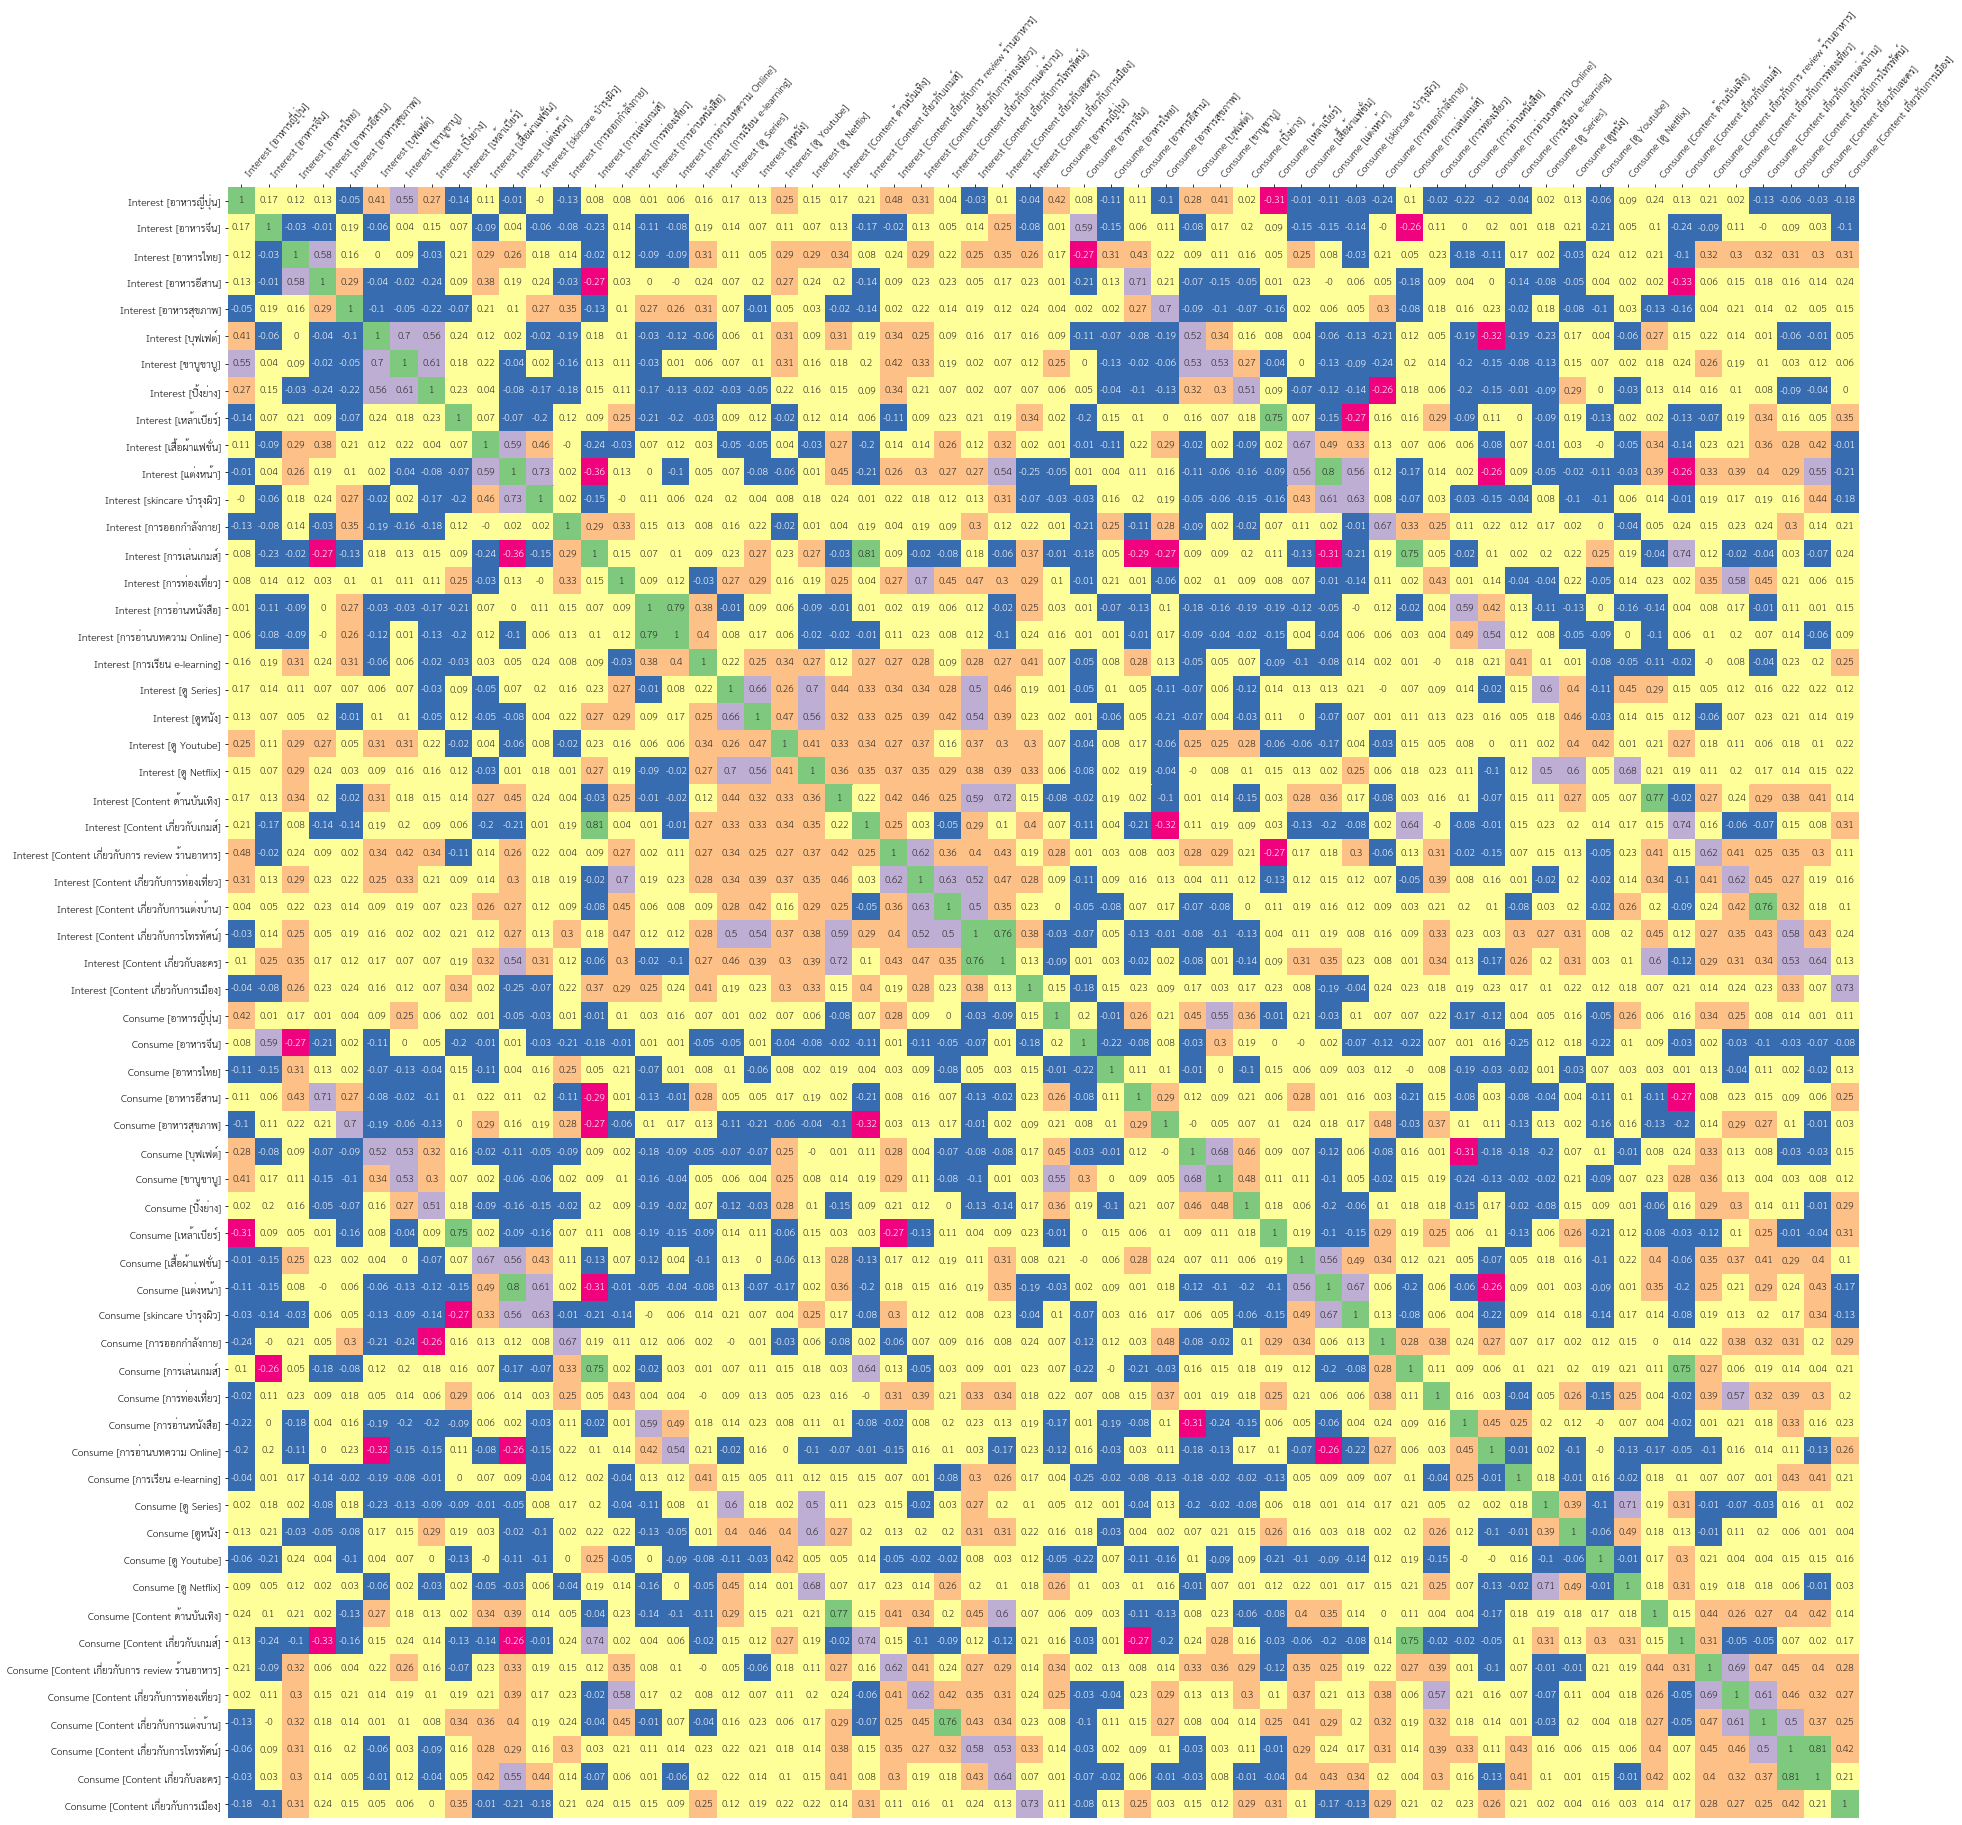

In [39]:
# Correlation
df_corr = df_tmp.corr()
for col in df_corr.columns[:]:
    df_corr[col] = np.round(df_corr[col].astype(float),decimals=2)   # round 
# Display heatmap
plt.figure(figsize=(30,30))
ax = sns.heatmap(df_corr , cmap='Accent_r', vmin=-1, vmax=1, annot=True, square=True, cbar=False , annot_kws={"size": 15 })
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, fontsize=15, ha='left', **csfont)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, **csfont )
plt.show()

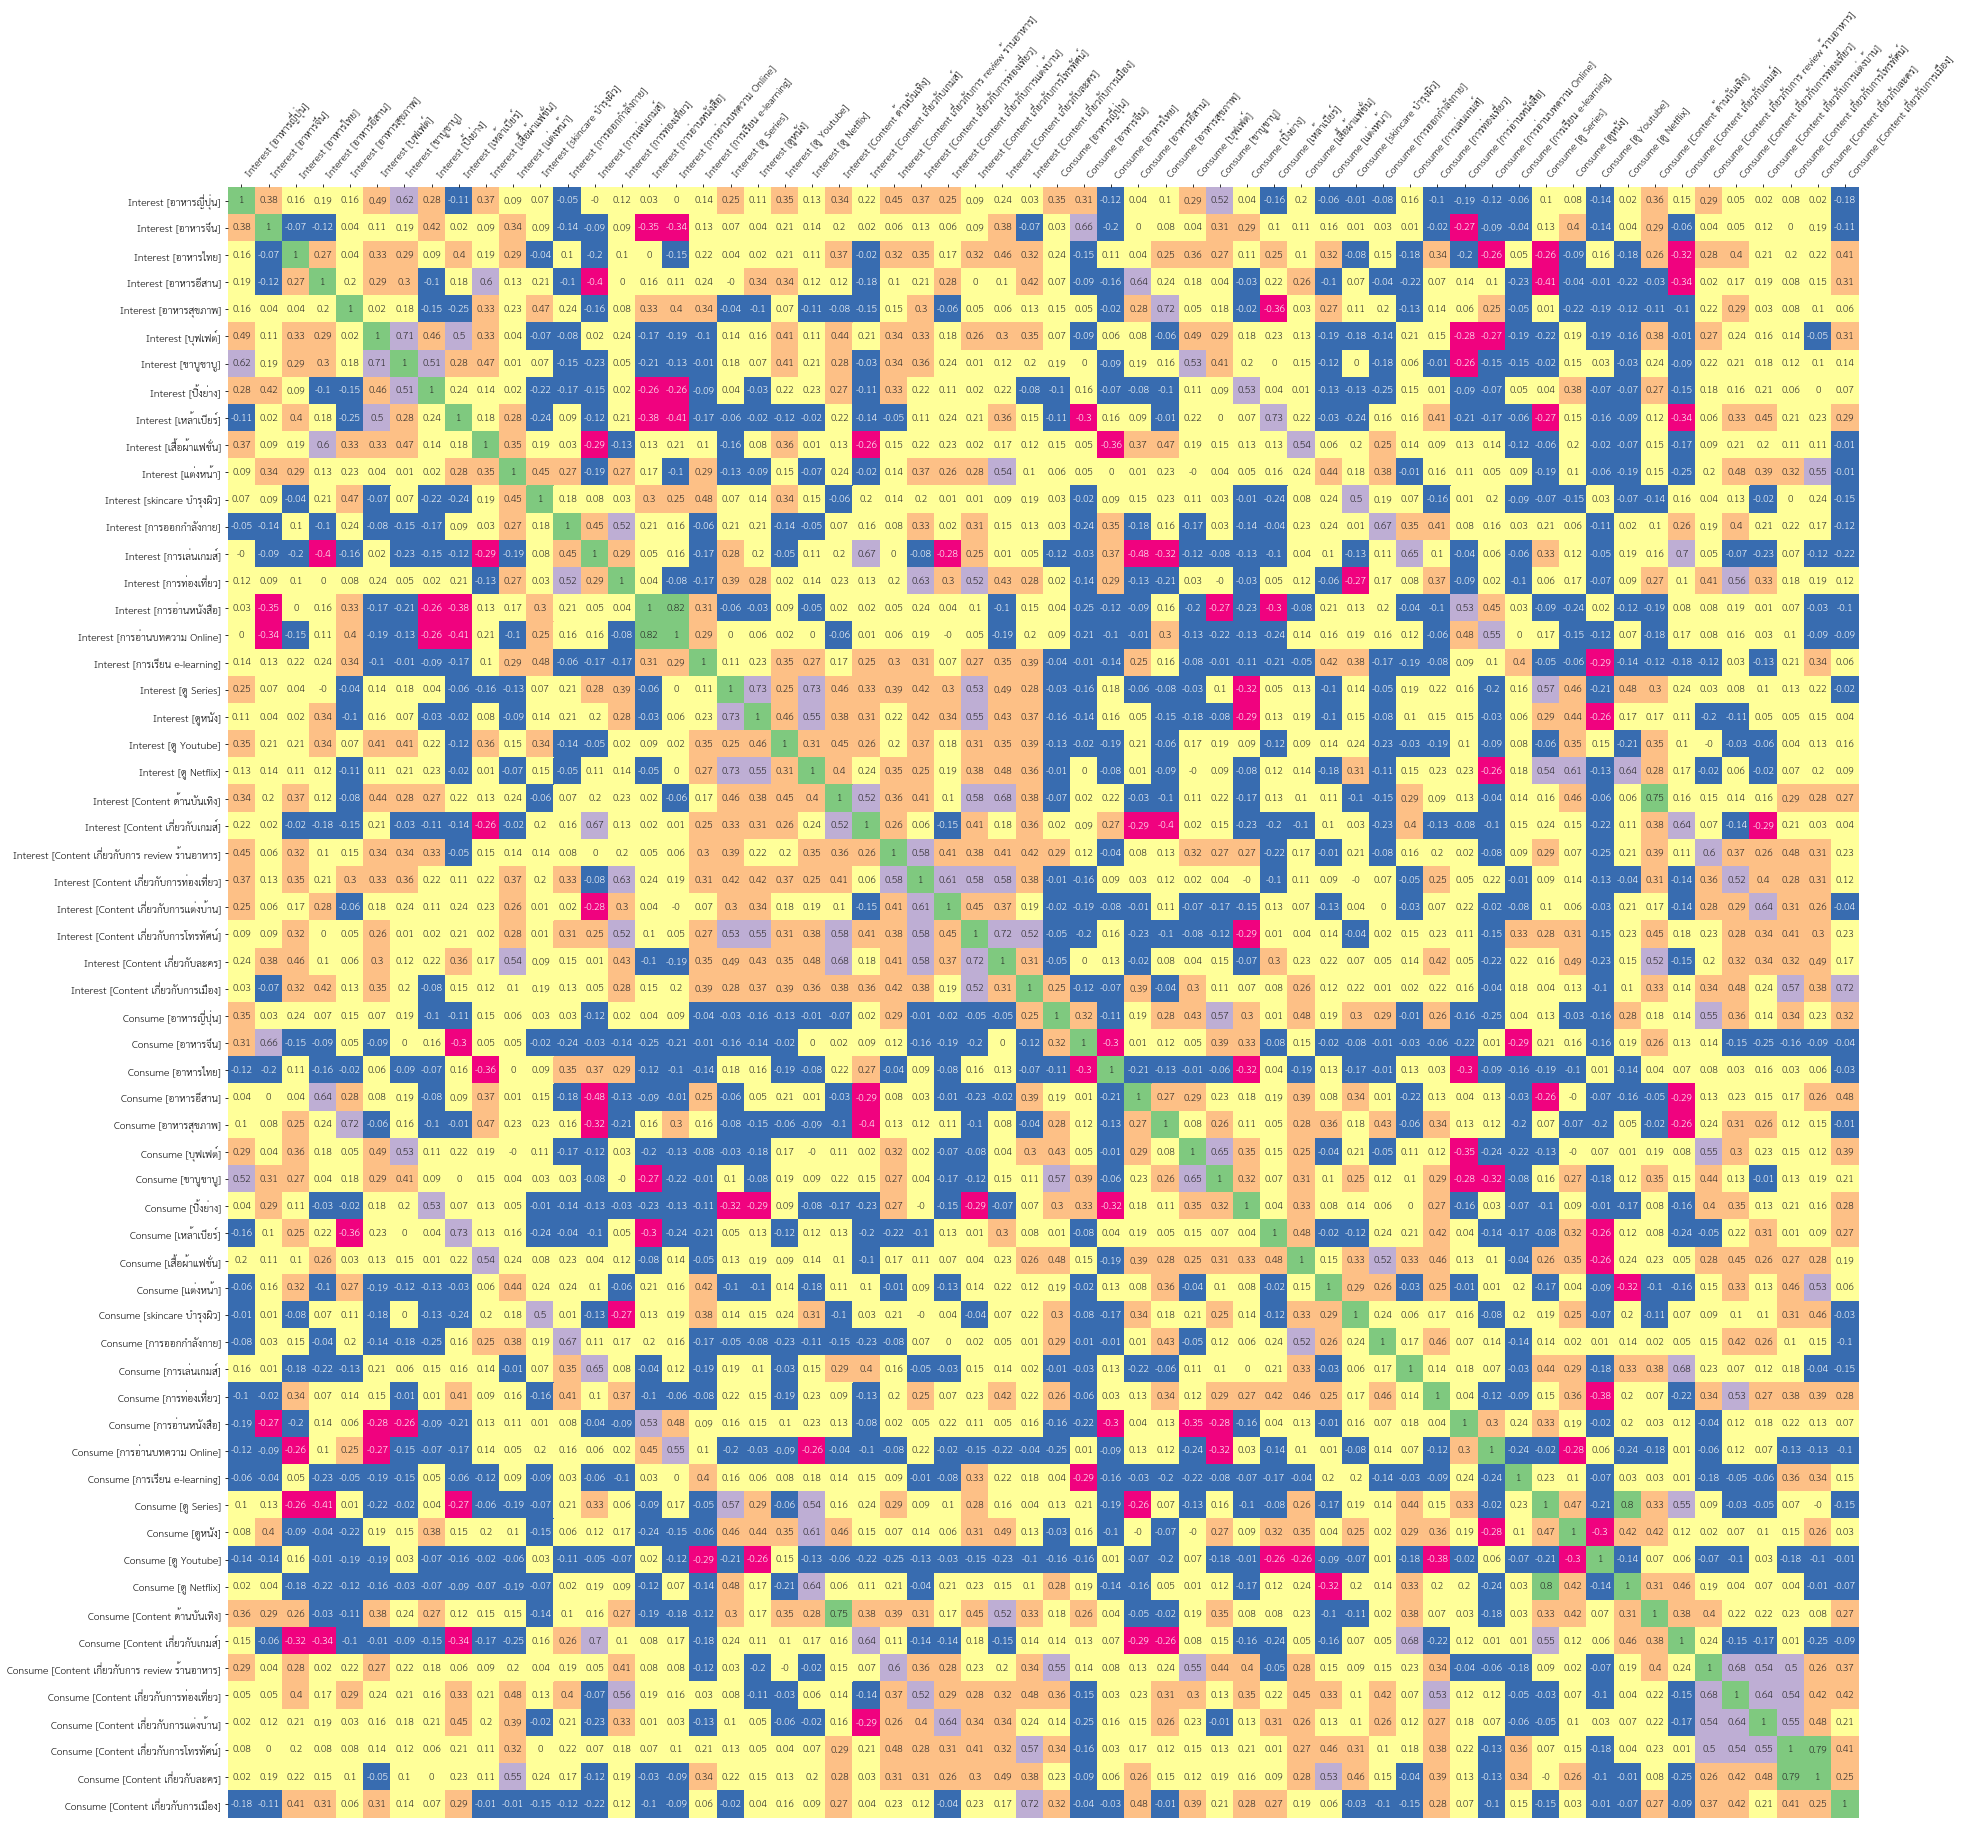

In [40]:
# Male Correlation
df_tmp = df_cop[df_cop['Gender']=='M']
df_corr_m = df_tmp[list(df_tmp.columns[:60])].corr()
for col in df_corr_m.columns[:]:
    df_corr_m[col] = np.round(df_corr_m[col].astype(float),decimals=2)   # round 

# Display heatmap
plt.figure(figsize=(30,30))
ax = sns.heatmap(df_corr_m , cmap='Accent_r', vmin=-1, vmax=1, annot=True, square=True, cbar=False, annot_kws={"size": 15 })
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, fontsize=15, ha='left', **csfont )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, **csfont )
plt.show()

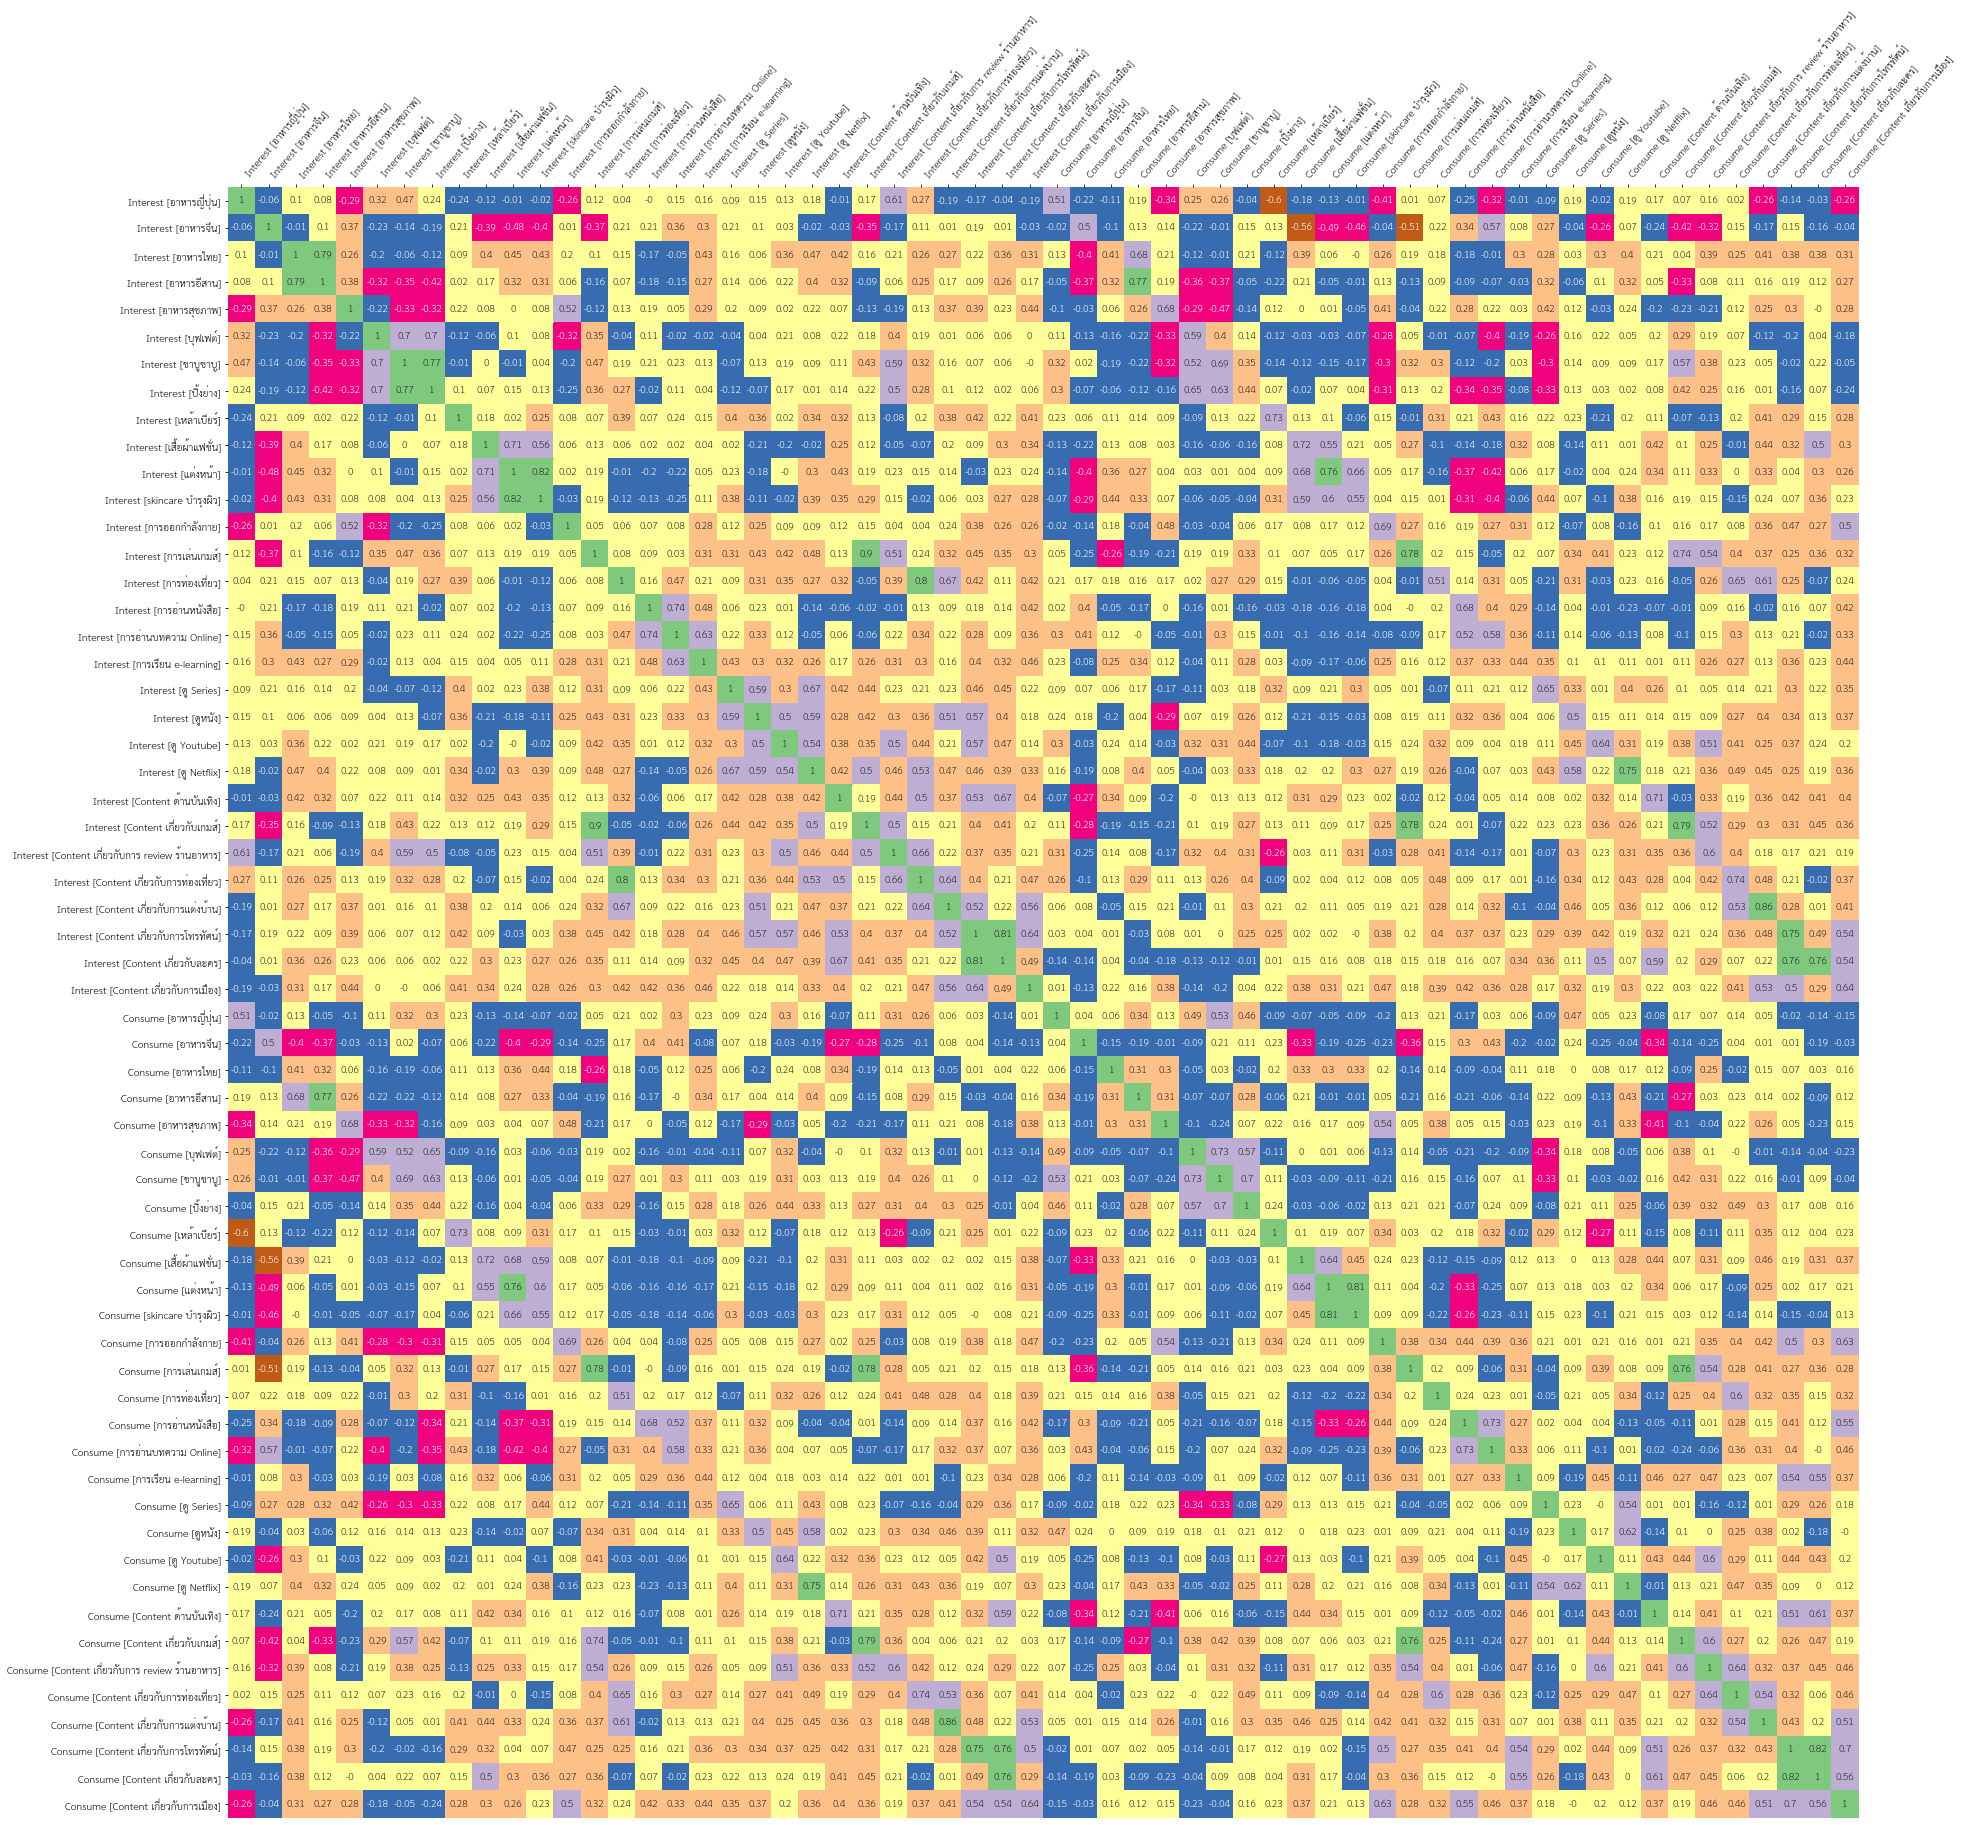

In [41]:
# Female Correlation
df_tmp = df_cop[df_cop['Gender']=='F']
df_corr_f = df_tmp[list(df_tmp.columns[:60])].corr()
for col in df_corr_f.columns[:]:
    df_corr_f[col] = np.round(df_corr_f[col].astype(float),decimals=2)   # round 
# Display heatmap
plt.figure(figsize=(30,30))
ax = sns.heatmap(df_corr_f , cmap='Accent_r', vmin=-1, vmax=1, annot=True, square=True, cbar=False, annot_kws={"size": 15 })
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, fontsize=15, ha='left', **csfont )
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, **csfont )
plt.show()

## Correlation Score

In [65]:
# Remove duplation correlation items
def remove_dup_corr(df_in):
  df_out = df_in.stack().reset_index() 
  df_out = df_out[df_out['level_0'].astype(str)!=df_out['level_1'].astype(str)]
  df_out['X'] = df_out.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
  df_out = df_out.drop_duplicates(['X'])
  df_out.drop(['X'], axis=1, inplace=True)    
  df_out.columns = ['Topic 1', 'Topic 2', 'Score']      
  df_out = df_out.sort_values('Score', ascending=False)   
  return df_out    

In [66]:
df_score = remove_dup_corr(df_corr) # Correlation Score both Male and Female
df_score 

,Topic 1,Topic 2,Score
803,Interest [การเล่นเกมส์],Interest [Content เกี่่ยวกับเกมส์],0.81
3478,Consume [Content เกี่ยวกับการโทรทัศน์],Consume [Content เกี่ยวกับละคร],0.81
640,Interest [แต่งหน้า],Consume [แต่งหน้า],0.80
916,Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],0.79
1372,Interest [Content ด้านบันเทิง],Consume [Content ด้านบันเทิง],0.77
...,...,...,...
820,Interest [การเล่นเกมส์],Consume [แต่งหน้า],-0.31
1414,Interest [Content เกี่่ยวกับเกมส์],Consume [อาหารสุขภาพ],-0.32
346,Interest [บุฟเฟต์],Consume [การอ่านบทความ Online],-0.32
233,Interest [อาหารอีสาน],Consume [Content เกี่่ยวกับเกมส์],-0.33


In [67]:
df_score_m = remove_dup_corr(df_corr_m) # Correlation Score Male
df_score_m

,Topic 1,Topic 2,Score
916,Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],0.82
2931,Consume [ดู Series],Consume [ดู Netflix],0.80
3478,Consume [Content เกี่ยวกับการโทรทัศน์],Consume [Content เกี่ยวกับละคร],0.79
1372,Interest [Content ด้านบันเทิง],Consume [Content ด้านบันเทิง],0.75
1099,Interest [ดู Series],Interest [ดูหนัง],0.73
...,...,...,...
1414,Interest [Content เกี่่ยวกับเกมส์],Consume [อาหารสุขภาพ],-0.40
193,Interest [อาหารอีสาน],Interest [การเล่นเกมส์],-0.40
228,Interest [อาหารอีสาน],Consume [ดู Series],-0.41
496,Interest [เหล้าเบียร์],Interest [การอ่านบทความ Online],-0.41


In [68]:
df_score_f = remove_dup_corr(df_corr_f)  # Correlation Score Female
df_score_f

,Topic 1,Topic 2,Score
803,Interest [การเล่นเกมส์],Interest [Content เกี่่ยวกับเกมส์],0.90
1616,Interest [Content เกี่ยวกับการแต่งบ้าน],Consume [Content เกี่ยวกับการแต่งบ้าน],0.86
3478,Consume [Content เกี่ยวกับการโทรทัศน์],Consume [Content เกี่ยวกับละคร],0.82
611,Interest [แต่งหน้า],Interest [skincare บำรุงผิว],0.82
1648,Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],0.81
...,...,...,...
70,Interest [อาหารจึน],Interest [แต่งหน้า],-0.48
100,Interest [อาหารจึน],Consume [แต่งหน้า],-0.49
103,Interest [อาหารจึน],Consume [การเล่นเกมส์],-0.51
99,Interest [อาหารจึน],Consume [เสื้อผ้าแฟชั่น],-0.56


# Another Interesting Analyze 
# Using part of code from Homework 11

In [46]:
# Build thai words for tokenizer
th_words = []
th_words.extend(list(thai_words())) 
th_words.extend(list(thai_stopwords()))
th_words.extend(list(thai_negations()))
th_words.extend(list(countries()))
th_words.extend(list(provinces()))

# add additional words
from pathlib import Path

url_a1 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_words.txt'
url_a2 = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/8001618620975c53c1742535958c124fdf207bef/HOMEWORK%2011/add_places.txt'
add_words = pd.read_fwf(url_a1, header=None)
add_places = pd.read_fwf(url_a2, header=None)
# additional words
th_words.extend(str(add_words).split('|')) 
th_words.extend(str(add_places).split('|')) 
th_words = set(th_words)

# remove from result list
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n','/n/n','/n', '(', ')', ':', '–', '"', ',','🤣','😆']
screening_words = stopwords + removed_words

def tokenize_with_space(text):
  text = normalize(str(text))
  custom_tokenizer = Tokenizer(th_words)
  words = custom_tokenizer.word_tokenize(text=text)
  words = [x for x in words if (x not in removed_words)]
  print(words)
  merged = ''
  for word in words:
    word = normalize(word)
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [47]:
df['Remark_tokenized'] = df['Remark'].apply(lambda x: tokenize_with_space(x))

['กีฬา', 'UFC', 'Soccer']
['กีฬา', 'สัตว์เลี้ยง', 'เทคโนโลยี']
['-']
['โหราศาสตร์', 'ดูดวง']
['สัตว์เลี้ยง']
['ด้าน', 'การออม', 'เงิน', 'วางแผนการ', 'ใช้', 'เงิน']
['อุปกรณ์', 'ไอที']
['ฟุตบอล', 'ถ่ายภาพ', 'รถยนต์', 'ผู้หญิง']
['Technology', 'Gadget', 'Shopping', 'Business']
['นอน']
['สัตว์เลี้ยง']
['ปลูก', 'ต้นไม้']
['วงการ', 'YouTuber']
['การออม', 'เงิน']
['ดนตรี']
['สัตว์เลี้ยง', 'น้อง', 'หมา', 'น้อง', 'แมว']
['ขายของ', 'ออนไลน์']
['ดนตรี']
['สัตว์เลี้ยง']
['ด้าน', 'การเกษตร']
['Gadget']
['Technology', 'and', 'Gadget']
['-']
['ดู', 'Anime']
['ดูดวง']
['Technology']
['การลงทุน']
['รถยนต์']
['กีฬา']
['กาแฟ', '/', 'ชา', 'นม', 'ไข่มุก']
['การลงทุน']
['ฟังเพลง', 'อ่าน', 'นิยาย', 'เทคโนโลยี']
['นิยาย', 'ออนไลน์', 'หุ้น']
['sports']
['การลงทุน', 'หา', 'แนวคิด', 'ใน', 'การ', 'ทำ', 'ธุรกิจ', 'เสริม']
['กีฬา', 'ฟุตบอล']
['ฟุตบอล', 'การท่องเที่ยว', 'แนว', 'ธรรมชาติ', 'รถยนต์', 'ธรรม', 'มะ', 'อาหาร', 'Anti-Aging']
['สัตว์เลี้ยง']
['สนใจ', 'เกี่ยวกับ', 'การตลาด', 'กลยุทธ์', 'ของ', 'เหล่า', 'บริษ

In [48]:
df1 = df
df1 = (df1['Remark_tokenized'].str.split(pat=',', expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))
print (df1)

            vals  count
0    สัตว์เลี้ยง     10
1         รถยนต์      5
2           กีฬา      5
3         ฟุตบอล      4
4      เทคโนโลยี      4
..           ...    ...
116       ผู้ชาย      1
117   โหราศาสตร์      1
118        สังคม      1
119          นอน      1
120                   1

[121 rows x 2 columns]


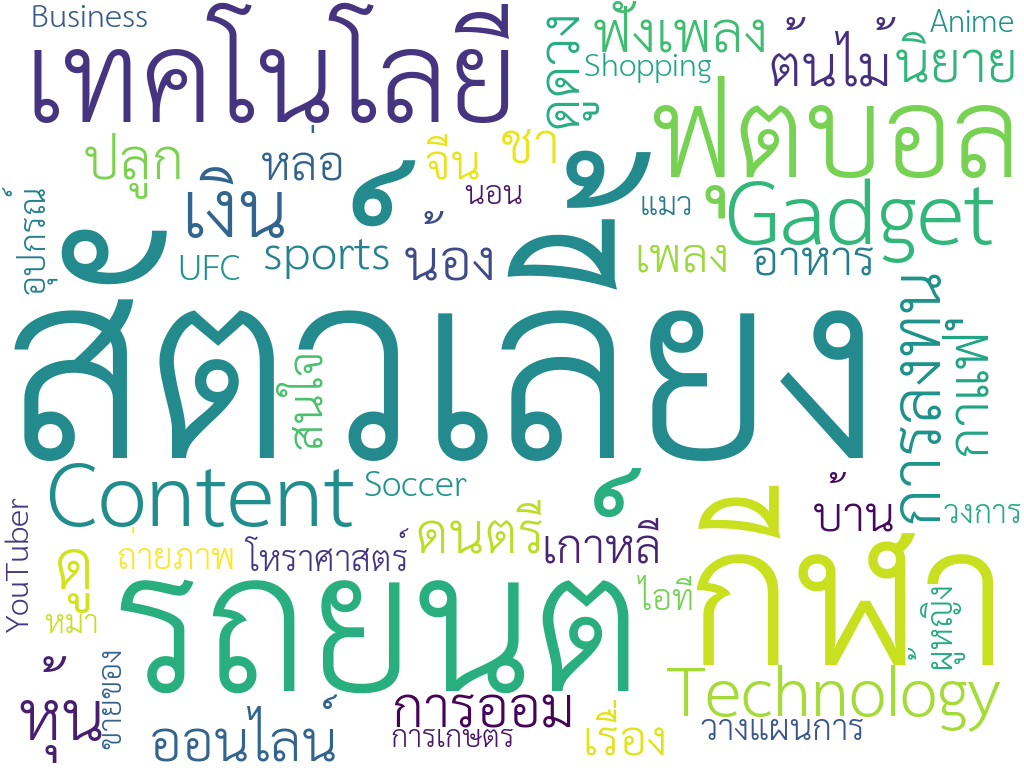

In [49]:
# Import the wordcloud library
from wordcloud import WordCloud
from os import path
# !wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
# !unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf
# !apt install fonts-thai-tlwg
# Join the different processed titles together.
long_string = ' '.join(df['Remark_tokenized'].values)
# # Create a WordCloud object
# WordCloud(font_path='THSarabunNew.ttf',
#                       background_color="white",
#                       width=1024, # กว้าง
#                       height=768, # ยาว
#                       collocations=False,
#                       regexp=r"[\u0E00-\u0E7Fa-zA-Z']+"
#                       ).generate(' '.join(df['Review_tokenized'].values()))
wordcloud = WordCloud(background_color="white", max_words=50, contour_width=1, contour_color='steelblue',font_path='THSarabunChula-Regular.ttf',
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+", collocations=False,width=1024,height=768) 
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()